____

**Data:** In this section, we use images (28X28, grayscale) of numbers (0-9) from the MNSIT database. These images have been rotated, scaled, zoomed and lit differently. The data contains 60000 images for the training set and 1000 images for the test set.


**Goal:** Predict the number from the images.

**Contact:** [stephanie.gnanalingam\@etu.u-paris.fr](mailto:stephanie.gnanalingam@etu.u-paris.fr)
____

# Import the packages

In [ ]:
# relating scikit-learn and Keras
!pip install scikeras

In [ ]:
import scikeras
from scikeras.wrappers import KerasClassifier

In [ ]:
# import and set important seeds
import os
os.environ['PYTHONHASHSEED']=str(42)
import random
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)
# to download the data from Github
import requests
import zipfile
from tqdm import tqdm
# ploting the models and their performances
from tensorflow import keras
keras.utils.set_random_seed(42)
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
# stock the data
import pandas as pd
from pandas import read_csv
# format the data
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# create the models CNN and Resnet
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
# for early stopping and saving of the best model
from tensorflow.keras import callbacks
# evaluate the model
import sklearn
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
# optimizing the model
from sklearn.model_selection import RandomizedSearchCV

# Mount Google Drive

**We suppose that you have downloaded the data and put it in the folder `/content/drive/MyDrive/M2BI_DRIVE/MNIST/`.**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
# create a new folder entitled M2BI_DRIVE if it does not exists
%mkdir M2BI_DRIVE
# get into it and set it as the working directory
%cd  /content/drive/MyDrive/M2BI_DRIVE
%pwd

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘M2BI_DRIVE’: File exists
/content/drive/MyDrive/M2BI_DRIVE


'/content/drive/MyDrive/M2BI_DRIVE'

# PRIOR ANALYSIS OF THE DATA

## Import the data

In [ ]:
train_images = np.load("MNIST/train_images.npy")
train_labels = np.load("MNIST/train_labels.npy")
test_images = np.load("MNIST/test_images.npy")
test_labels = np.load("MNIST/test_labels.npy")

## Visualize the data

In [ ]:
print("Shape of train images:")
print(train_images.shape)
print("Shape of train labels:")
print(train_labels.shape)
print("Type of the images:")
print(type(train_images[0, 0, 0, 0]))
print("First 5 rows of train images:\n", train_images[:5])
print("First 5 elements of train labels:\n", train_labels[:5])
print("First 5 rows of train images:\n", test_images[:5])
print("First 5 elements of train labels:\n", test_labels[:5])

Shape of train images:
(60000, 28, 28, 1)
Shape of train labels:
(60000,)
Type of the images:
<class 'numpy.float32'>
First 5 rows of train images:
 [[[[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  ...

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  

**Interpretation:**

train_images shape : (60000, 28, 28, 1) -> 60000 images, 28X28 dimension, 1 channel/grayscale.

train_labels shape : (60000,) -> a vector containing numbers from 0 to 9.

The pixels are of type float32, making easier the calculations

In [ ]:
print("Shape of test images:")
print(test_images.shape)
print("Shape of test labels:")
print(test_labels.shape)
print("Type of the images:")
print(type(test_images[0, 0, 0, 0]))

Shape of test images:
(10000, 28, 28, 1)
Shape of test labels:
(10000,)
Type of the images:
<class 'numpy.uint8'>


**Interpretation:**

The shape is coherent with the instructions. However, the data type of test images has to be modified.

Text(0.5, 0, 'Classes')

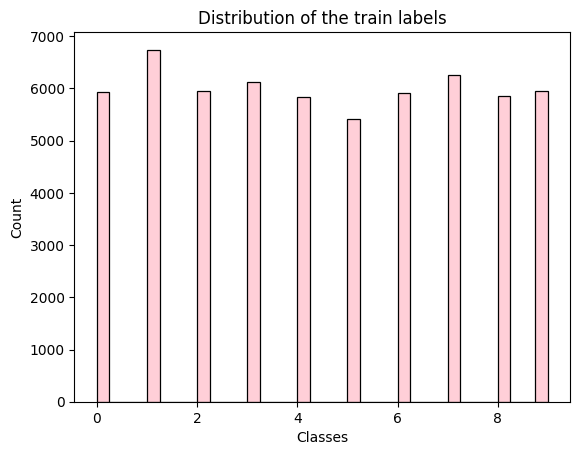

In [ ]:
sns.histplot(train_labels, color="pink", edgecolor="black")
plt.title("Distribution of the train labels")
plt.xlabel("Classes")

**Interpretation:**

The classes seems to be equally distributed. However, we can still adjust the weights to be sure that each class is considered equally during the learning process.

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 1.0130001688333614, 1: 0.8899436369029962, 2: 1.0070493454179255, 3: 0.978633175664655, 4: 1.0270455323519343, 5: 1.1068068622025458, 6: 1.013856032443393, 7: 0.9577015163607342, 8: 1.025465732353444, 9: 1.0085728693898135}



## Plot some images

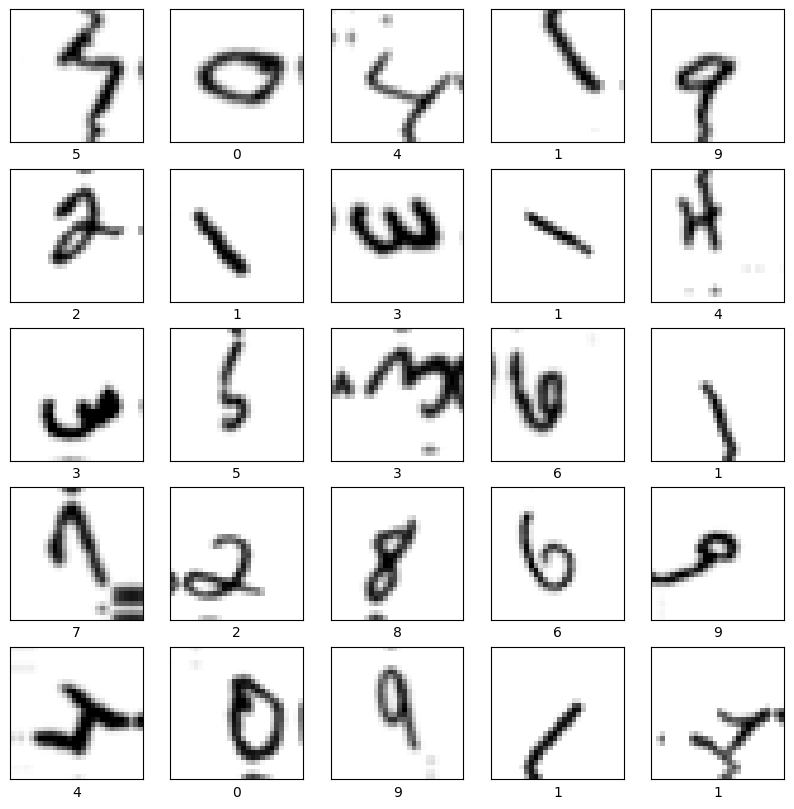

In [ ]:
plt.figure(figsize=[10,10])
for i in range (25):
  # for each image, we give it an id where it will be placed
  plt.subplot(5, 5, i+1)
  # we don't want any name for the axis
  plt.xticks([])
  plt.yticks([])
  # plot the images with the coloscale being a binary(0 or 1)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  # plot the labels associated
  plt.xlabel(train_labels[i])
plt.show()

## DATA TRANSFORMATION

In [ ]:
num_pixels = train_images.shape[1] * train_images.shape[2]
num_pixels # dimension of one image

784

In [ ]:
train_images = train_images.reshape(train_images.shape[0], num_pixels)
test_images = test_images.reshape(test_images.shape[0], num_pixels)
print("Shape of train images:")
print(train_images.shape)
print("Shape of test images:")
print(test_images.shape)

Shape of train images:
(60000, 784)
Shape of test images:
(10000, 784)


The train data is already normalized.

In [ ]:
# uint8 -> float32
test_images = test_images.astype('float32')
# normalize the test data
test_images = test_images / 255.0

In [ ]:
print("Shape of train images:")
print(train_images.shape)
print("Shape of train labels:")
print(train_labels.shape)
print("Type of the images:")
print(type(train_images[0, 0]))

print("Shape of test images:")
print(test_images.shape)
print("Shape of test labels:")
print(test_labels.shape)
print("Type of the images:")
print(type(test_images[0, 0]))

Shape of train images:
(60000, 784)
Shape of train labels:
(60000,)
Type of the images:
<class 'numpy.float32'>
Shape of test images:
(10000, 784)
Shape of test labels:
(10000,)
Type of the images:
<class 'numpy.float32'>


**Interpretation:**

The data is coherent.

In [ ]:
# One hot encoding (OHE) of the labels
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
print("Train labels OHE:")
print(train_labels[:5])
print("Test labels OHE:")
print(test_labels[:5])

Train labels OHE:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Test labels OHE:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
# shuffle the training data to avoid patterns
# permutation of the indexes from 0 to 60000
shuffle_indexes = np.random.permutation(train_images.shape[0])
# sorting the data according to the previous order
train_images, train_labels = train_images[shuffle_indexes,:], train_labels[shuffle_indexes,]

# CALLBACK STRATEGY

**The more the number of epoch is high and the more we have a risk of overfitting. In order to avoid that, we will have an option to stop the training if the accuracy on the validation set doesn't improve significantly.**

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_weighted_accuracy', patience=20, mode='max')

**As the epoch increases, the performances can change. That's why it is important to save the best model all along the training.**

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# MODEL 1 : Dense neural network

In [ ]:
def simple_dnn():
    """Create a DNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    # first hidden layer with 256 neurons
    model.add(Dense(256, input_dim=num_pixels, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='relu'))
    # add a dropout of 30%
    model.add(Dropout(.3))
    # add another hidden layer of 128 neurons
    model.add(Dense(128, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='relu'))
    # add the softmax layer
    model.add(Dense(num_classes,  kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

## Summary

In [ ]:
dnn_model = simple_dnn()
print(f'{dnn_model.summary()}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


**Interpretation:**

dense -> 784 (input) * 256 (output) + 256 (bias) = 200960

dense_1 -> 256 (input) * 128 (output) + 128 (bias) = 32896

dense_2 -> 128 (input) * 10 (output) + 10 (bias) = 1290

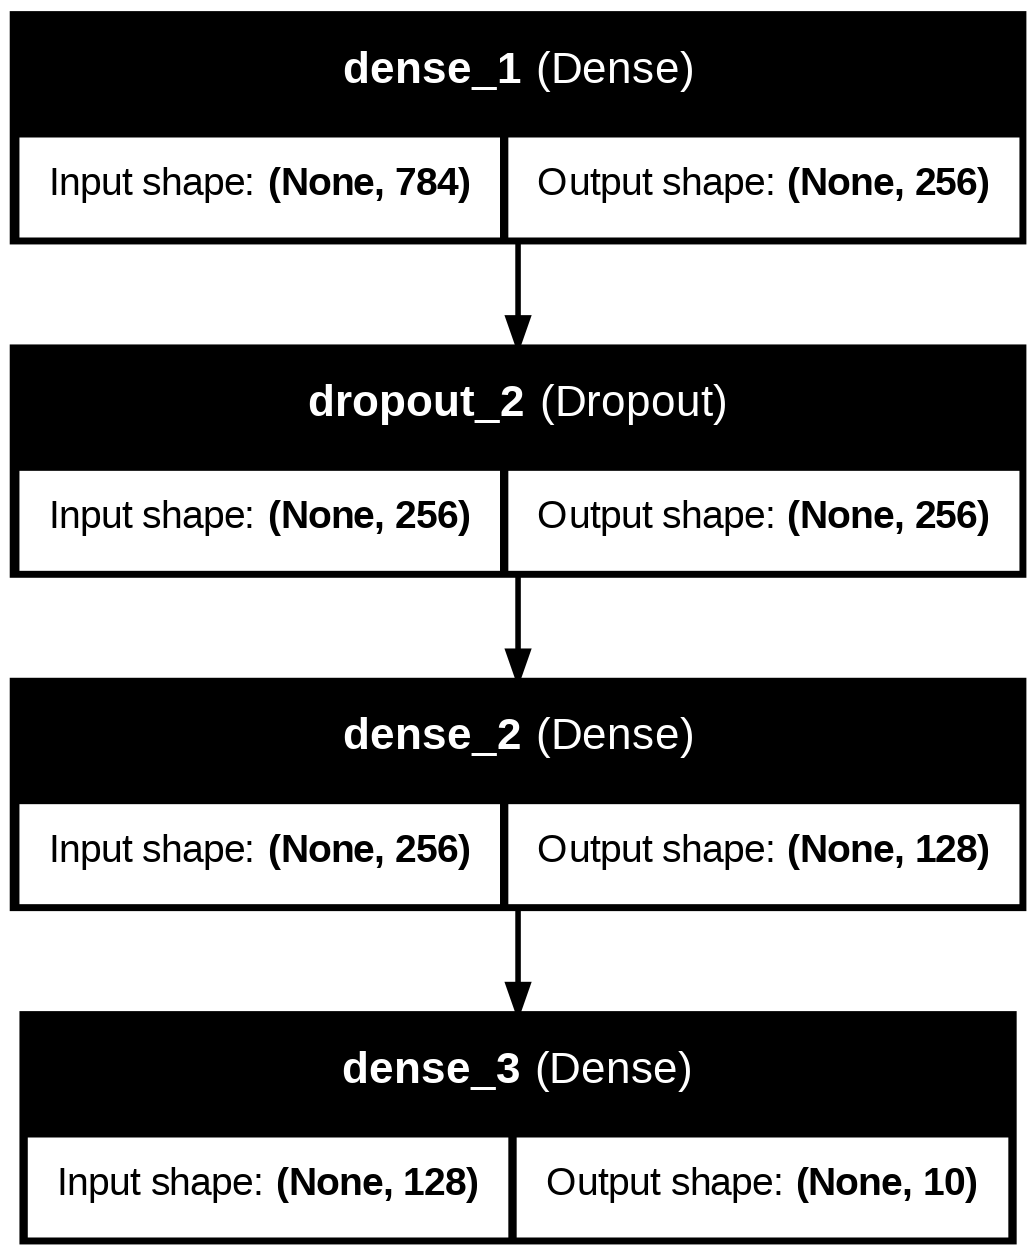

In [ ]:
plot_model(dnn_model, to_file="model_dnn.png", show_shapes=True, show_layer_names=True)

## Training

In [ ]:
# early stopping was removed due to convergence issues
dnn_history = dnn_model.fit(train_images, train_labels, validation_split=0.2, epochs=60, batch_size=100, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)

Epoch 1/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2817 - loss: 2.0058 - weighted_accuracy: 0.2790 - val_accuracy: 0.6019 - val_loss: 1.2340 - val_weighted_accuracy: 0.6019
Epoch 2/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5666 - loss: 1.3133 - weighted_accuracy: 0.5605 - val_accuracy: 0.6912 - val_loss: 0.9728 - val_weighted_accuracy: 0.6912
Epoch 3/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6442 - loss: 1.0994 - weighted_accuracy: 0.6394 - val_accuracy: 0.7358 - val_loss: 0.8374 - val_weighted_accuracy: 0.7358
Epoch 4/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6841 - loss: 0.9804 - weighted_accuracy: 0.6798 - val_accuracy: 0.7589 - val_loss: 0.7629 - val_weighted_accuracy: 0.7589
Epoch 5/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7146 - loss: 0.8984 - weighted_accuracy: 0.7108 - val_accuracy: 0.7752 - val_loss: 0.7155 - val_weighted_accuracy: 0.7752
Epoch 6/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc

## Performance

In [ ]:
def plot_performances(m_history):
  """
  Plot the performances of a model.

  Parameters:
  -----------
  History object

  Returns:
  --------
  None
  """
  plt.plot(m_history.history['weighted_accuracy'])
  plt.plot(m_history.history['val_weighted_accuracy'])
  plt.title('Model weighted accuracy')
  plt.ylabel('Weighted ccuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

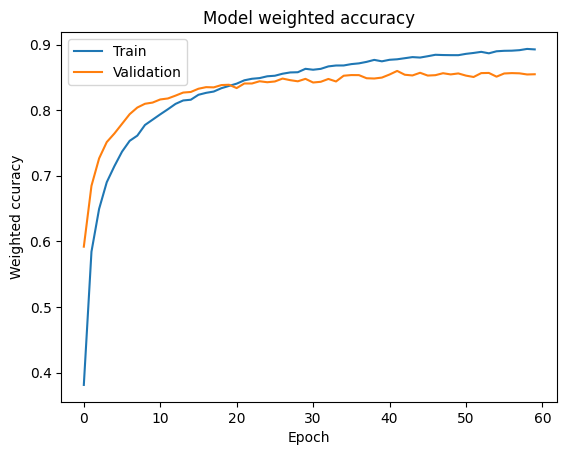

In [ ]:
plot_performances(dnn_history)

**Interpretation:**

The validation curve is higher than the training one. The test data are maybe easier to predict. The performance is between 0.6-0.7 which is not fantastic but reasonable. The fact that the images are noised can explain why the predictions are hard.

## Evaluating the performance on test data

In [ ]:
dnn_model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8520 - loss: 0.5353 - weighted_accuracy: 0.8520


[0.47404322028160095,
 0.8672999739646912,
 0.8672999739646912,
 0.8672999739646912]

**Interpretation:**

The accuracy is 0.56 which is not fantastic. Our model is not as much generalizable as expected. However, this is the best model we have generated.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Text(0.5, 1.0, 'Confusion matrix of the true vs predicted digits')

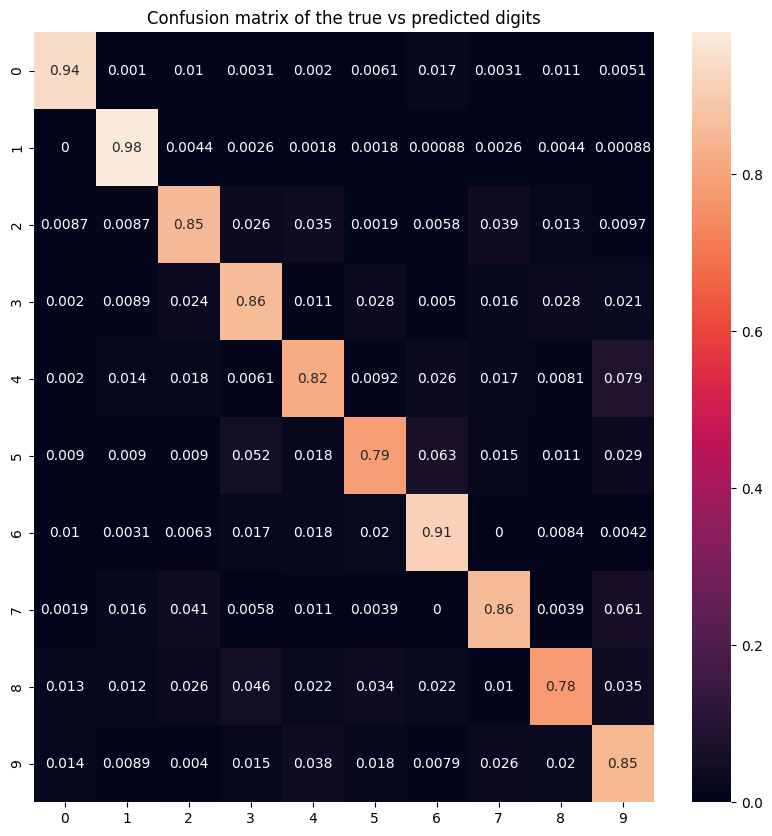

In [ ]:
y_pred = dnn_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(test_labels, axis = 1)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(sklearn.metrics.confusion_matrix(y_true_classes, y_pred_classes, normalize="true"), annot=True)
plt.title("Confusion matrix of the true vs predicted digits")

**Interpretation:**

Globally, we predict all the classes with a percentage between 20% and 95% which is good. There are some classes which are complicated to explain (4, 5, 9).

# ROC curve and precision-recall curve

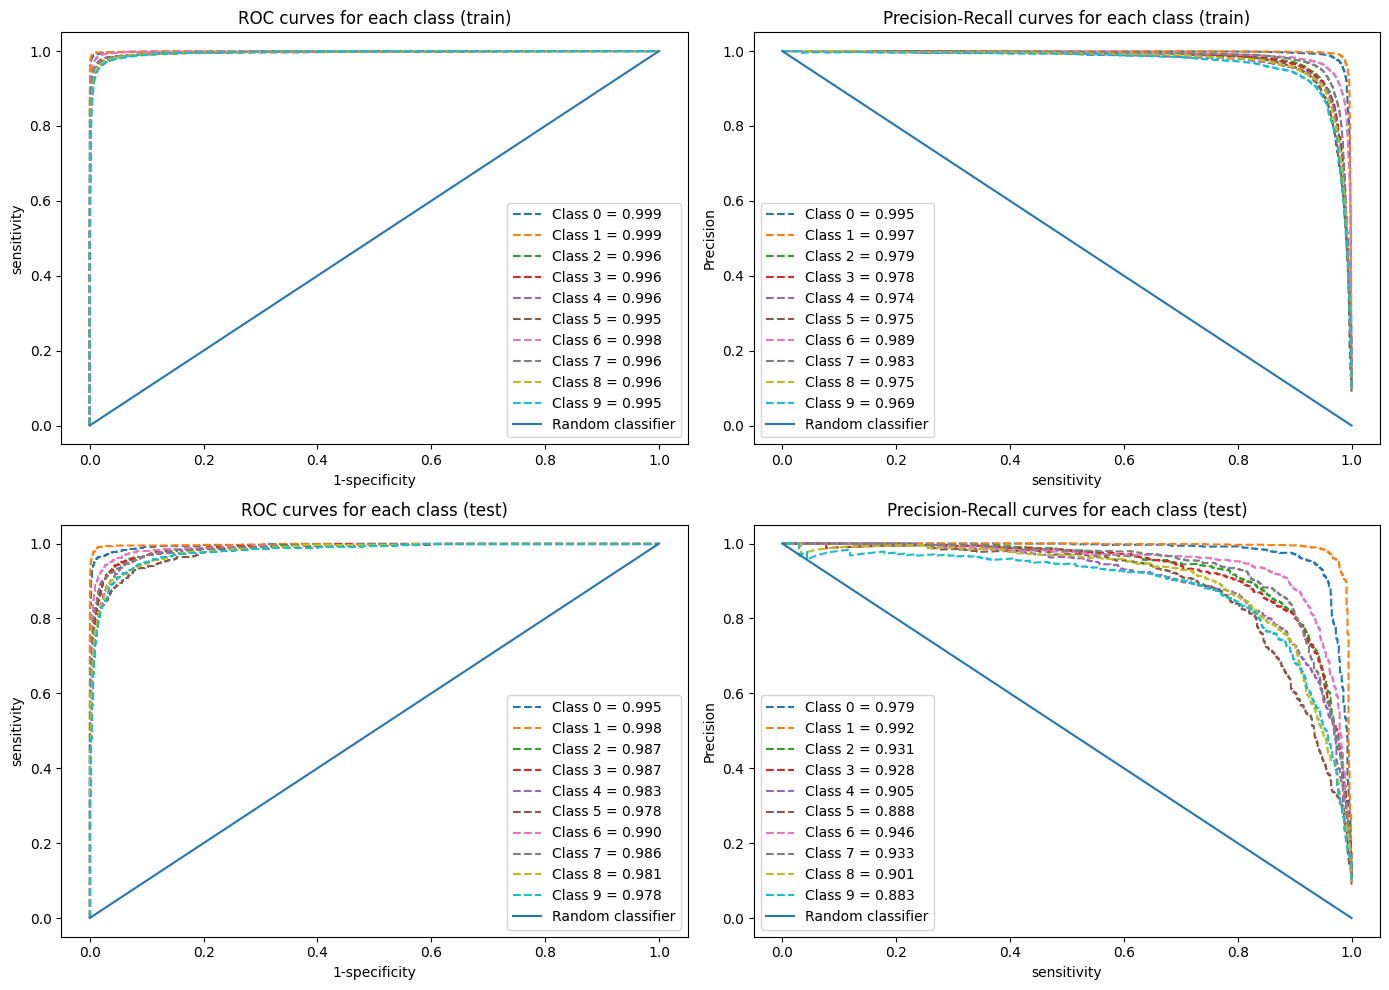

In [ ]:
# setting the axis for the final plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize = (14,10))
n_classes = 10

for i in range(n_classes):
    # we take the i-th class as the true labels
    # the only sequences with the label 1 will be that of the class i
    # the others will be at 0
    y_train_true = train_labels[:, i]
    y_test_true = test_labels[:, i]

    # calculate the predicted classes for train et test sets
    # we take the i-th class predictions
    train_pred = dnn_model.predict(train_images, verbose=0)[:, i]
    test_pred = dnn_model.predict(test_images, verbose=0)[:, i]

    # roc_curve enables to set thresholds and calculate FPR and TPR
    train_fpr, train_tpr, _ = roc_curve(y_train_true, train_pred)
    test_fpr, test_tpr, _ = roc_curve(y_test_true, test_pred)

    # calculate the area under the ROC curve
    auc_train = sklearn.metrics.auc(train_fpr, train_tpr)
    auc_test = sklearn.metrics.auc(test_fpr, test_tpr)

    ax1.plot(train_fpr, train_tpr, linestyle='--', label=f"Class {i} = {auc_train:.3f}")
    ax3.plot(test_fpr, test_tpr, linestyle='--', label=f"Class {i} = {auc_test:.3f}")

    # procede the same for precision-recall
    train_precision, train_recall, _ = precision_recall_curve(y_train_true, train_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test_true, test_pred)

    aupr_train = sklearn.metrics.average_precision_score(y_train_true, train_pred)
    aupr_test = sklearn.metrics.average_precision_score(y_test_true, test_pred)

    ax2.plot(train_recall, train_precision, linestyle='--', label=f"Class {i} = {aupr_train:.3f}")
    ax4.plot(test_recall, test_precision, linestyle='--', label=f"Class {i} = {aupr_test:.3f}")

# plot the random classifier for comparison
ax1.plot([0, 1], [0, 1], label='Random classifier')
ax1.set_xlabel('1-specificity')
ax1.set_ylabel('sensitivity')
ax1.set_title('ROC curves for each class (train)')
ax3.plot([0, 1], [0, 1], label='Random classifier')
ax3.set_xlabel('1-specificity')
ax3.set_ylabel('sensitivity')
ax3.set_title('ROC curves for each class (test)')

ax2.plot([0, 1], [1, 0], label='Random classifier')
ax2.set_xlabel('sensitivity')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves for each class (train)')
ax4.plot([0, 1], [1, 0], label='Random classifier')
ax4.set_xlabel('sensitivity')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall curves for each class (test)')

# to separate correctly each sub-graph
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

**Interpretation:**

One vs all strategy. The ROC curve and precision-recall curve for the train are great. The prediction on the train are good but it is normal because the model is trained on it. However, the results are heterogen for the test set. There are some classes which are not predicted well (8, 4, ...). Nevertheless, the predictions are better than a random classifier.

# Cross-validation

**In order to compare different models, we need to do a cross-validation**

In [ ]:
training = KerasClassifier(build_fn=dnn_model, epochs=60, batch_size=100,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross validation accuracies: [0.90225    0.895      0.90216667 0.8985     0.90091667]
Results Cross validation : 89.98% (0.27%)


**Interpretation:**

Cross-validation divides the training dataset into several sub-sets. This allows us to see if the model is generalizable or if there are observations that condition the training. Here, we can see that our CV has great results (high accuracy, small standard error). Our model is robust.

The learning rate [0.0001-0.01], epochs [60, 100] and batch-size [40-100] had been modified to improve the performances. To avoid redundancy, all the results hadn't been shown. The best model was the one with respectively : [0.001, 60, 80]

# MODEL 2 : CNN

We are going to perform a CNN in order to see if the performances improve.

## Change the data

In [ ]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

print("Shape of train images:")
print(train_images.shape)
print("Shape of train labels:")
print(train_labels.shape)
print("Type of the images:")
print(type(train_images[0, 0, 0, 0]))

print("Shape of test images:")
print(test_images.shape)
print("Shape of test labels:")
print(test_labels.shape)
print("Type of the images:")
print(type(test_images[0, 0, 0, 0]))

Shape of train images:
(60000, 28, 28, 1)
Shape of train labels:
(60000, 10)
Type of the images:
<class 'numpy.float32'>
Shape of test images:
(10000, 28, 28, 1)
Shape of test labels:
(10000, 10)
Type of the images:
<class 'numpy.float32'>


In [ ]:
def simple_cnn():
    """Create a CNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    # add the softmax layer
    model.add(Dense(num_classes, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

In [ ]:
cnn_model = simple_cnn()
print(f'{cnn_model.summary()}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          62,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,178 (246.79 KB)

 Trainable params: 63,114 (246.54 KB)

 Non-trainable params: 64 (256.00 B)

None


**Interpretation:**

conv2d <- 32 (nombre de filtres) * 3 * 3 (taille du kernel) + 32 (biais)

batch_normalization <- 32 (nombre de filtres) + 32 (gamma) + 32 (beta) + 32 (moyenne) + 32 (écart-type)

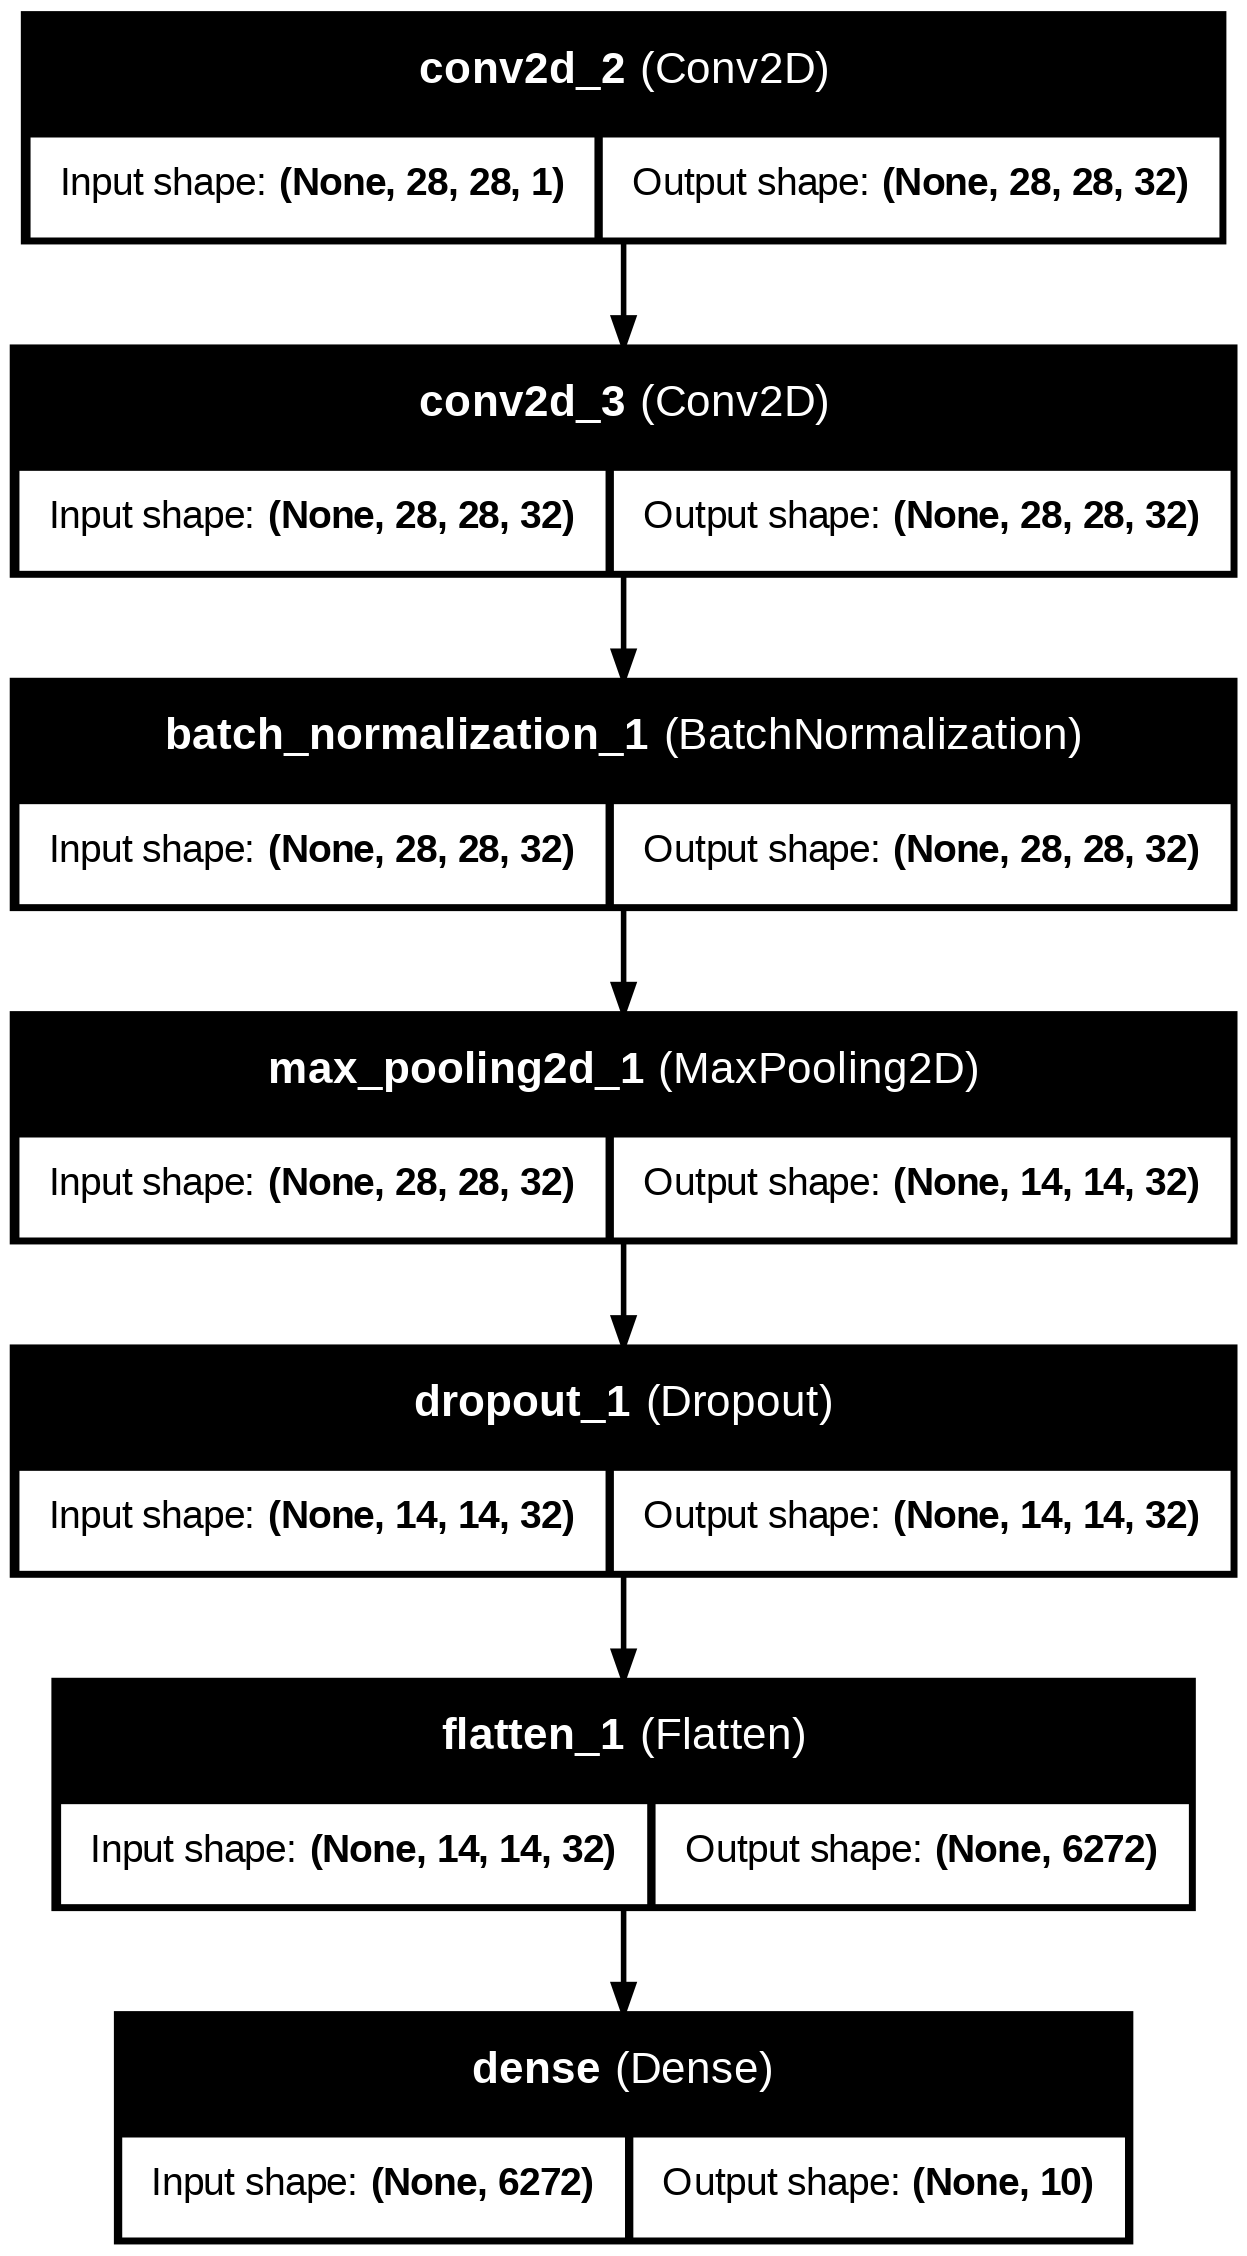

In [ ]:
plot_model(cnn_model, to_file="model_cnn.png", show_shapes=True, show_layer_names=True)

In [ ]:
cnn_history = cnn_model.fit(train_images, train_labels, validation_split=0.2, epochs=10, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.3338 - loss: 2.2789 - weighted_accuracy: 0.3294 - val_accuracy: 0.5304 - val_loss: 1.3859 - val_weighted_accuracy: 0.5304
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.5363 - loss: 1.4170 - weighted_accuracy: 0.5318 - val_accuracy: 0.6080 - val_loss: 1.1910 - val_weighted_accuracy: 0.6080
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.5955 - loss: 1.2353 - weighted_accuracy: 0.5914 - val_accuracy: 0.6363 - val_loss: 1.1113 - val_weighted_accuracy: 0.6363
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.6262 - loss: 1.1435 - weighted_accuracy: 0.6220 - val_accuracy: 0.6494 - val_loss: 1.0848 - val_weighted_accuracy: 0.6494
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.6479 - loss: 1.0822 - weighted_accuracy: 0.6439 - val_accuracy: 0.6553 - val_loss: 1.0668 - val_weighted_accuracy: 0.6553
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/

In [ ]:
training = KerasClassifier(build_fn=cnn_model, epochs=10, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross validation accuracies: [0.74875    0.75016667 0.75708333 0.74583333 0.75225   ]
Results Cross validation : 75.08% (0.38%)


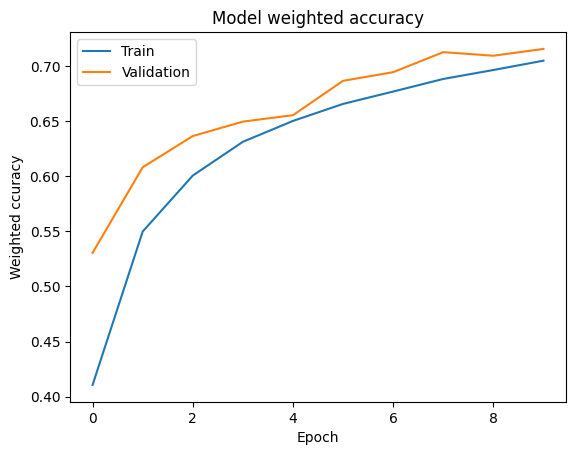

In [ ]:
plot_performances(cnn_history)

In [ ]:
cnn_model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7142 - loss: 0.9152 - weighted_accuracy: 0.7142


[0.8615913987159729,
 0.7271000146865845,
 0.7271000146865845,
 0.7271000146865845]

**Interpretation:**

The performances are good with a correct curves and test accuracy. However, the number of epochs needs to be increased in order to have a better learning.

In [ ]:
# increasing the number of epoch
cnn_model = simple_cnn()
cnn_history = cnn_model.fit(train_images, train_labels, validation_split=0.2, epochs=40, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)
print(cnn_model.evaluate(test_images, test_labels))
training = KerasClassifier(build_fn=simple_cnn, epochs=40, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.3324 - loss: 2.2815 - weighted_accuracy: 0.3281 - val_accuracy: 0.5184 - val_loss: 1.4233 - val_weighted_accuracy: 0.5184
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.5328 - loss: 1.4254 - weighted_accuracy: 0.5281 - val_accuracy: 0.5974 - val_loss: 1.2238 - val_weighted_accuracy: 0.5974
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.5928 - loss: 1.2393 - weighted_accuracy: 0.5883 - val_accuracy: 0.6258 - val_loss: 1.1271 - val_weighted_accuracy: 0.6258
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.6253 - loss: 1.1480 - weighted_accuracy: 0.6213 - val_accuracy: 0.6583 - val_loss: 1.0608 - val_weighted_accuracy: 0.6583
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.6457 - loss: 1.0910 - weighted_accuracy: 0.6417 - val_accuracy: 0.6716 - val_loss: 1.0210 - val_weighted_accuracy: 0.6716
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/s

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross validation accuracies: [0.78958333 0.79158333 0.78316667 0.78666667 0.78658333]
Results Cross validation : 78.75% (0.29%)


**Interpretation:**

The performances are better than the previous model.

# MODEL 3 : CNN

We are going to increase the number of filters to see if there is an impact on the model.

In [ ]:
def simple_cnn_1():
    """Create a CNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    # add the softmax layer
    model.add(Dense(num_classes, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 88s 142ms/step - accuracy: 0.3436 - loss: 2.9569 - weighted_accuracy: 0.3391 - val_accuracy: 0.4216 - val_loss: 1.7774 - val_weighted_accuracy: 0.4216
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 84s 141ms/step - accuracy: 0.5522 - loss: 1.4679 - weighted_accuracy: 0.5478 - val_accuracy: 0.4965 - val_loss: 1.5859 - val_weighted_accuracy: 0.4965
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.6398 - loss: 1.1391 - weighted_accuracy: 0.6359 - val_accuracy: 0.6246 - val_loss: 1.1508 - val_weighted_accuracy: 0.6246
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - accuracy: 0.6786 - loss: 1.0102 - weighted_accuracy: 0.6750 - val_accuracy: 0.6922 - val_loss: 0.9823 - val_weighted_accuracy: 0.6922
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 143ms/step - accuracy: 0.7010 - loss: 0.9288 - weighted_accuracy: 0.6975 - val_accuracy: 0.7219 - val_loss: 0.8862 - val_weighted_accuracy: 0.7219
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 136s

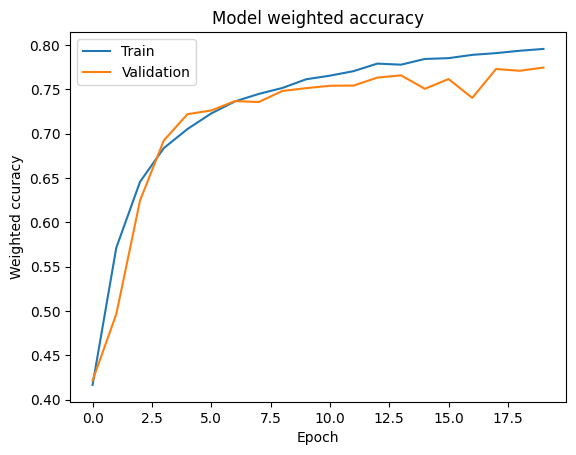

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7747 - loss: 0.7492 - weighted_accuracy: 0.7747
[0.6786519289016724, 0.7921000123023987, 0.7921000123023987, 0.7921000123023987]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Cross validation accuracies: [0.76715 0.7564  0.76175]
Results Cross validation : 76.18% (0.44%)


In [ ]:
cnn_1_model = simple_cnn_1()
cnn_1_history = cnn_1_model.fit(train_images, train_labels, validation_split=0.2, epochs=20, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)
plot_performances(cnn_1_history)
print(cnn_1_model.evaluate(test_images, test_labels))
training = KerasClassifier(build_fn=simple_cnn_1, epochs=20, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

**Interpretation:**

This model is better than the previous CNN. Increasing the number of filters seems to improve the performances.

Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 99s 164ms/step - accuracy: 0.3438 - loss: 2.9623 - weighted_accuracy: 0.3394 - val_accuracy: 0.4080 - val_loss: 1.8649 - val_weighted_accuracy: 0.4080
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 134s 151ms/step - accuracy: 0.5474 - loss: 1.4834 - weighted_accuracy: 0.5430 - val_accuracy: 0.5097 - val_loss: 1.5237 - val_weighted_accuracy: 0.5097
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.6280 - loss: 1.1725 - weighted_accuracy: 0.6240 - val_accuracy: 0.6262 - val_loss: 1.1500 - val_weighted_accuracy: 0.6262
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 141s 150ms/step - accuracy: 0.6737 - loss: 1.0247 - weighted_accuracy: 0.6700 - val_accuracy: 0.6777 - val_loss: 1.0101 - val_weighted_accuracy: 0.6777
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 140s 147ms/step - accuracy: 0.6985 - loss: 0.9466 - weighted_accuracy: 0.6950 - val_accuracy: 0.7022 - val_loss: 0.9487 - val_weighted_accuracy: 0.7022
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 9

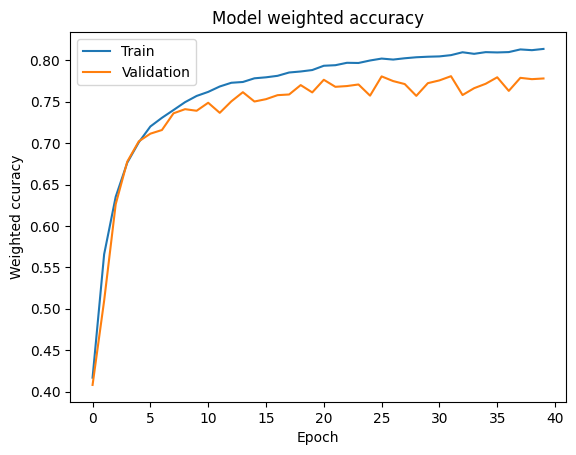

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7834 - loss: 0.7353 - weighted_accuracy: 0.7834
[0.6716185808181763, 0.798799991607666, 0.798799991607666, 0.798799991607666]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# increase the number of epoch
cnn_1_model = simple_cnn_1()
cnn_1_history = cnn_1_model.fit(train_images, train_labels, validation_split=0.2, epochs=40, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)
plot_performances(cnn_1_history)
print(cnn_1_model.evaluate(test_images, test_labels))
training = KerasClassifier(build_fn=simple_cnn_1, epochs=20, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

**Interpretation:**

Increasing the number of epoch seems to worsen the training.

# MODEL 4

We are going to add another layer to see whether it improves the performances.

In [ ]:
def simple_cnn_2():
    """Create a CNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    # add the softmax layer
    model.add(Dense(num_classes, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 215s 356ms/step - accuracy: 0.3934 - loss: 1.9489 - weighted_accuracy: 0.3894 - val_accuracy: 0.6771 - val_loss: 0.9623 - val_weighted_accuracy: 0.6771
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 264s 360ms/step - accuracy: 0.7597 - loss: 0.7648 - weighted_accuracy: 0.7572 - val_accuracy: 0.7333 - val_loss: 0.8896 - val_weighted_accuracy: 0.7333
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 215s 358ms/step - accuracy: 0.8199 - loss: 0.5905 - weighted_accuracy: 0.8179 - val_accuracy: 0.7770 - val_loss: 0.8129 - val_weighted_accuracy: 0.7770
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 257s 349ms/step - accuracy: 0.8407 - loss: 0.5272 - weighted_accuracy: 0.8388 - val_accuracy: 0.8185 - val_loss: 0.6372 - val_weighted_accuracy: 0.8185
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 263s 350ms/step - accuracy: 0.8552 - loss: 0.4762 - weighted_accuracy: 0.8537 - val_accuracy: 0.8321 - val_loss: 0.5873 - val_weighted_accuracy: 0.8321
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 

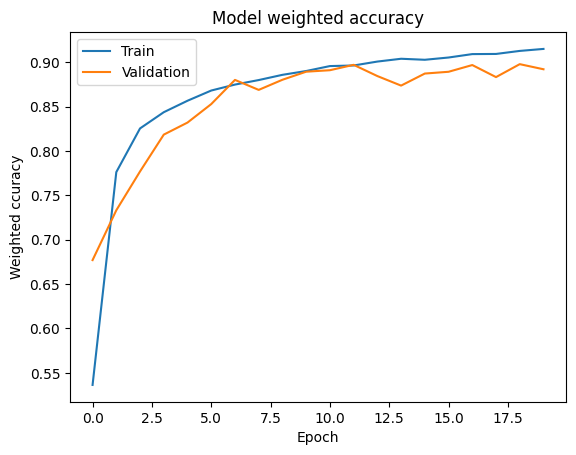

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8922 - loss: 0.3704 - weighted_accuracy: 0.8922
[0.3265358805656433, 0.9045000076293945, 0.9045000076293945, 0.9045000076293945]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Cross validation accuracies: [0.8746 0.8935 0.8884]
Results Cross validation : 88.55% (0.80%)


In [ ]:
cnn_2_model = simple_cnn_2()
cnn_2_history = cnn_2_model.fit(train_images, train_labels, validation_split=0.2, epochs=20, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)
plot_performances(cnn_2_history)
print(cnn_2_model.evaluate(test_images, test_labels))
training = KerasClassifier(build_fn=simple_cnn_2, epochs=20, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

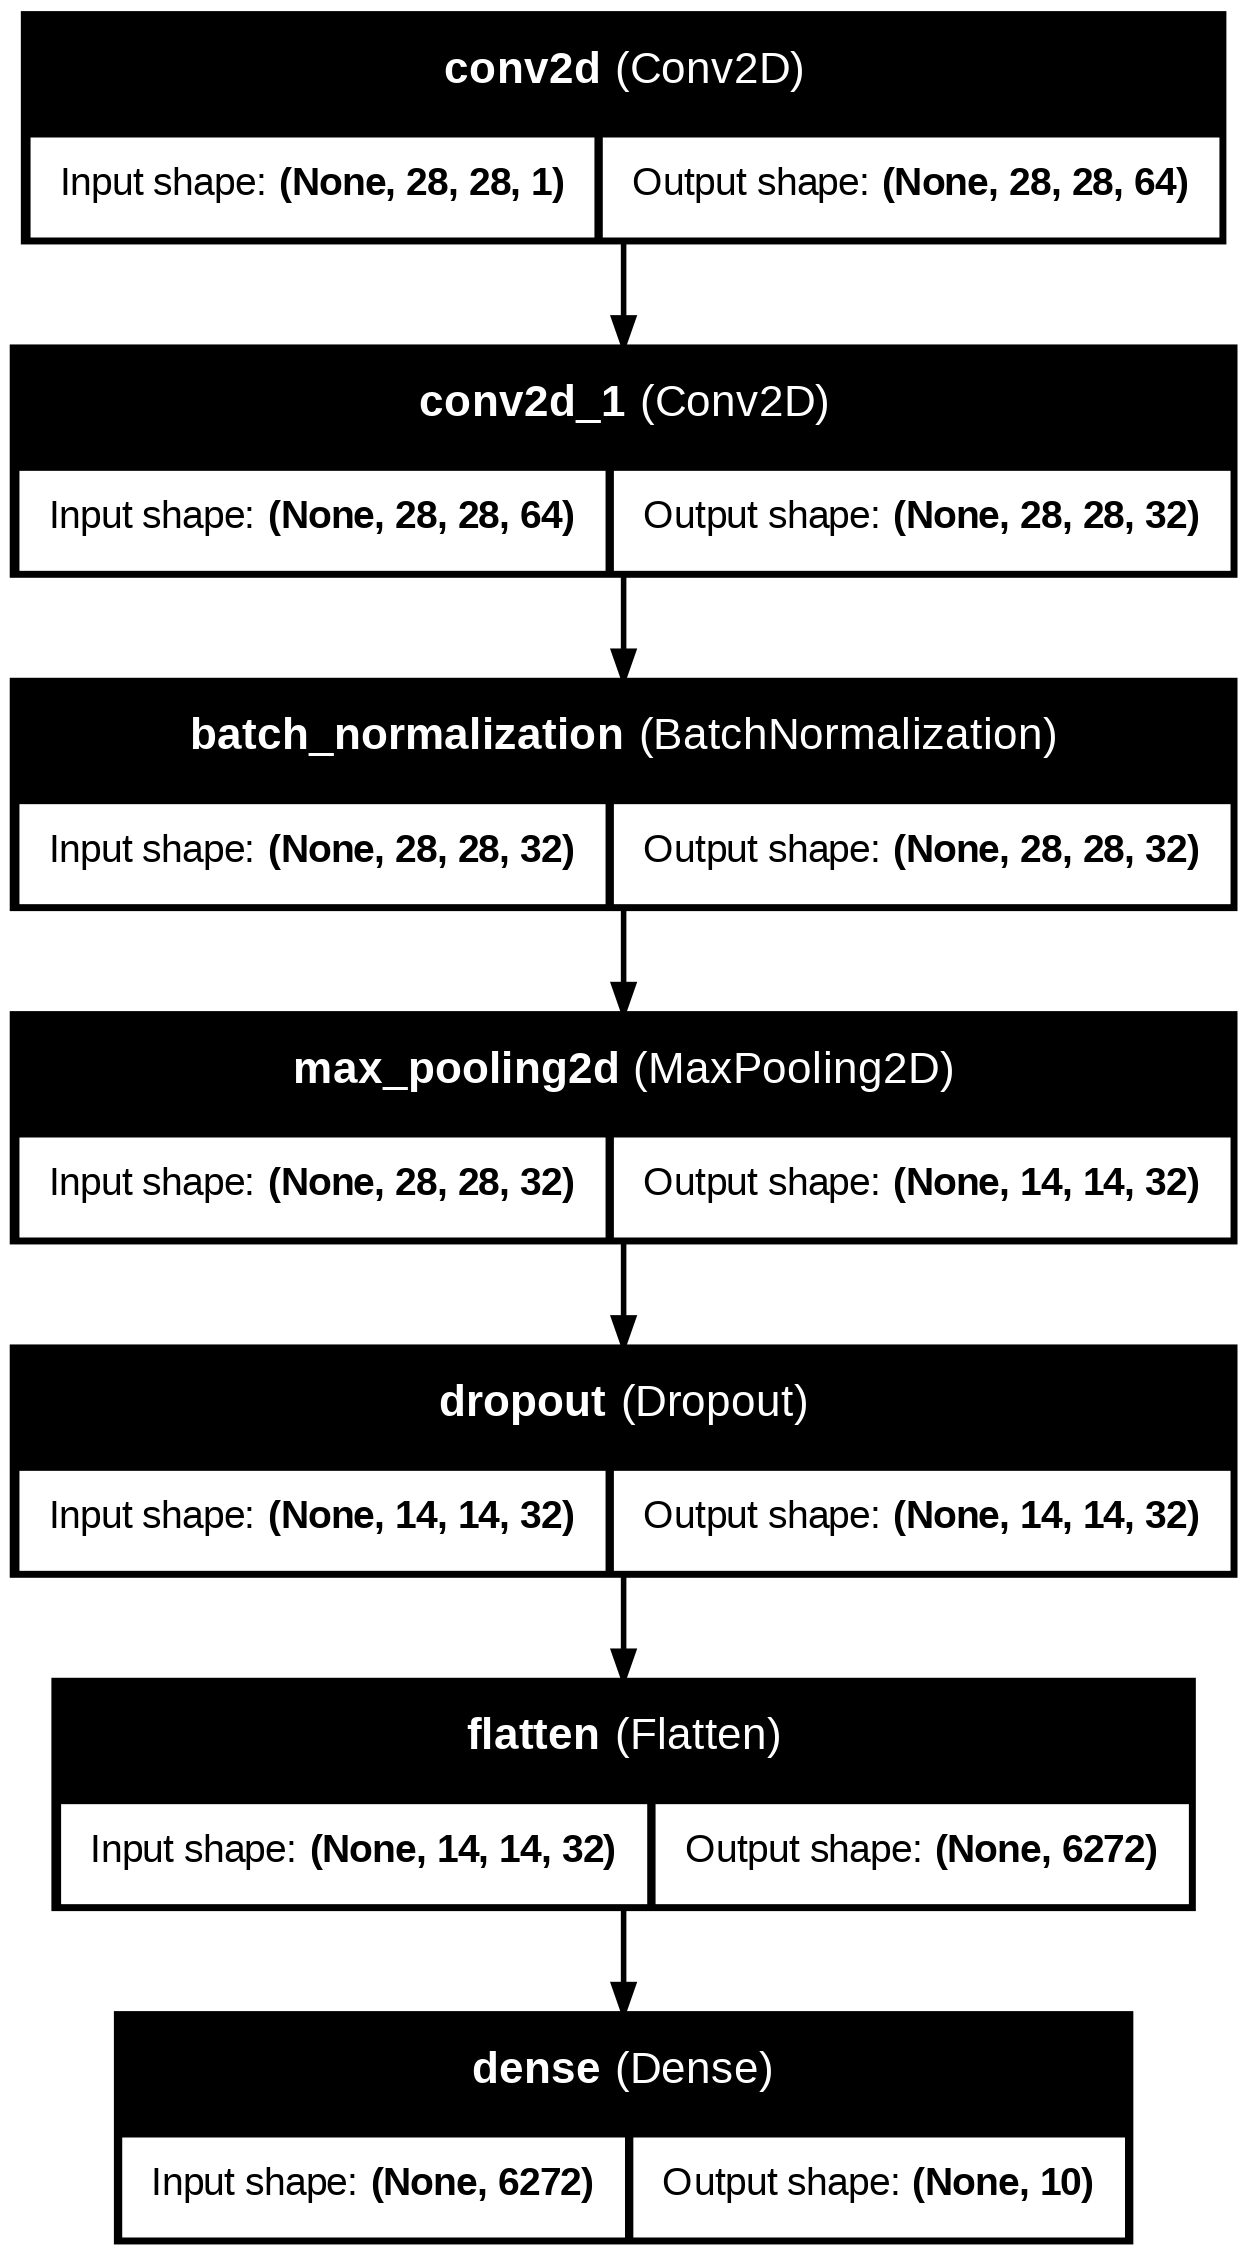

In [ ]:
plot_model(cnn_2_model, to_file="model_cnn_4.png", show_shapes=True, show_layer_names=True)

**Interpretation:**

Adding another layer improved the performances by 10% which is great.

# MODEL 5

In [ ]:
def simple_cnn_3():
    """Create a CNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    # add the softmax layer
    model.add(Dense(num_classes, kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 280s 463ms/step - accuracy: 0.3503 - loss: 2.0307 - weighted_accuracy: 0.3467 - val_accuracy: 0.7105 - val_loss: 0.8827 - val_weighted_accuracy: 0.7105
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 318s 457ms/step - accuracy: 0.7462 - loss: 0.8076 - weighted_accuracy: 0.7434 - val_accuracy: 0.8344 - val_loss: 0.5482 - val_weighted_accuracy: 0.8344
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 323s 459ms/step - accuracy: 0.8292 - loss: 0.5617 - weighted_accuracy: 0.8274 - val_accuracy: 0.8477 - val_loss: 0.4979 - val_weighted_accuracy: 0.8477
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 435ms/step - accuracy: 0.8582 - loss: 0.4693 - weighted_accuracy: 0.8567 - val_accuracy: 0.8727 - val_loss: 0.4219 - val_weighted_accuracy: 0.8727
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 270s 451ms/step - accuracy: 0.8772 - loss: 0.4034 - weighted_accuracy: 0.8760 - val_accuracy: 0.8761 - val_loss: 0.4300 - val_weighted_accuracy: 0.8761
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 

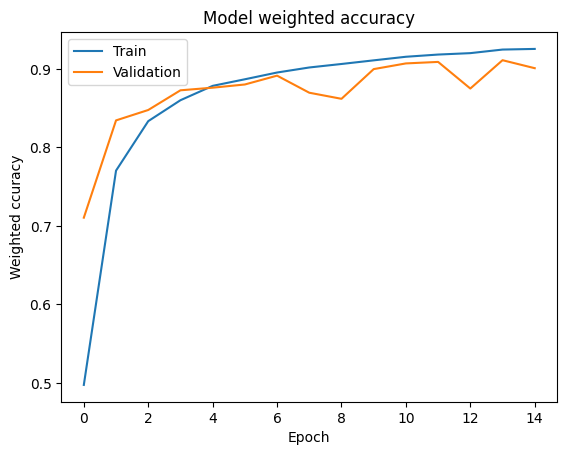

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9030 - loss: 0.3348 - weighted_accuracy: 0.9030
[0.30702608823776245, 0.9100000262260437, 0.9100000262260437, 0.9100000262260437]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Cross validation accuracies: [0.89905 0.91405 0.91065]
Results Cross validation : 90.79% (0.64%)


In [ ]:
cnn_3_model = simple_cnn_3()
cnn_3_history = cnn_3_model.fit(train_images, train_labels, validation_split=0.2, epochs=15, batch_size=80, class_weight=class_weights, callbacks=[model_checkpoint], shuffle=False)
plot_performances(cnn_3_history)
print(cnn_3_model.evaluate(test_images, test_labels))
training = KerasClassifier(build_fn=simple_cnn_3, epochs=15, batch_size=80,verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_results = cross_val_score(training, train_images, train_labels, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

# Best model performances

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step


Text(0.5, 1.0, 'Confusion matrix of the true vs predicted digits')

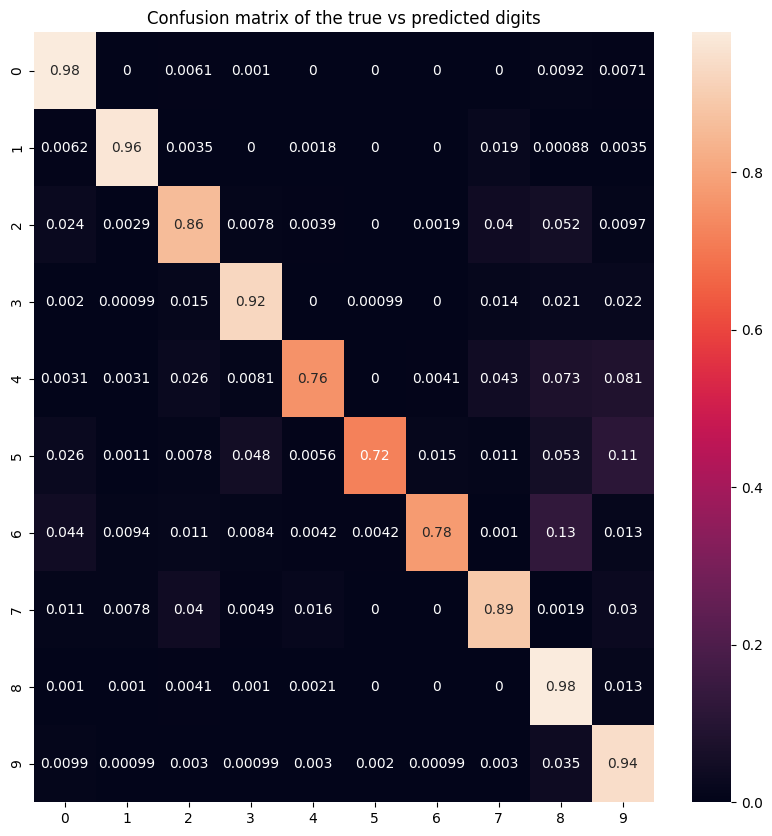

In [ ]:
plot_model(cnn_3_model, to_file="model_cnn_3.png", show_shapes=True, show_layer_names=True)
y_pred = cnn_3_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(test_labels, axis = 1)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(sklearn.metrics.confusion_matrix(y_true_classes, y_pred_classes, normalize="true"), annot=True)
plt.title("Confusion matrix of the true vs predicted digits")

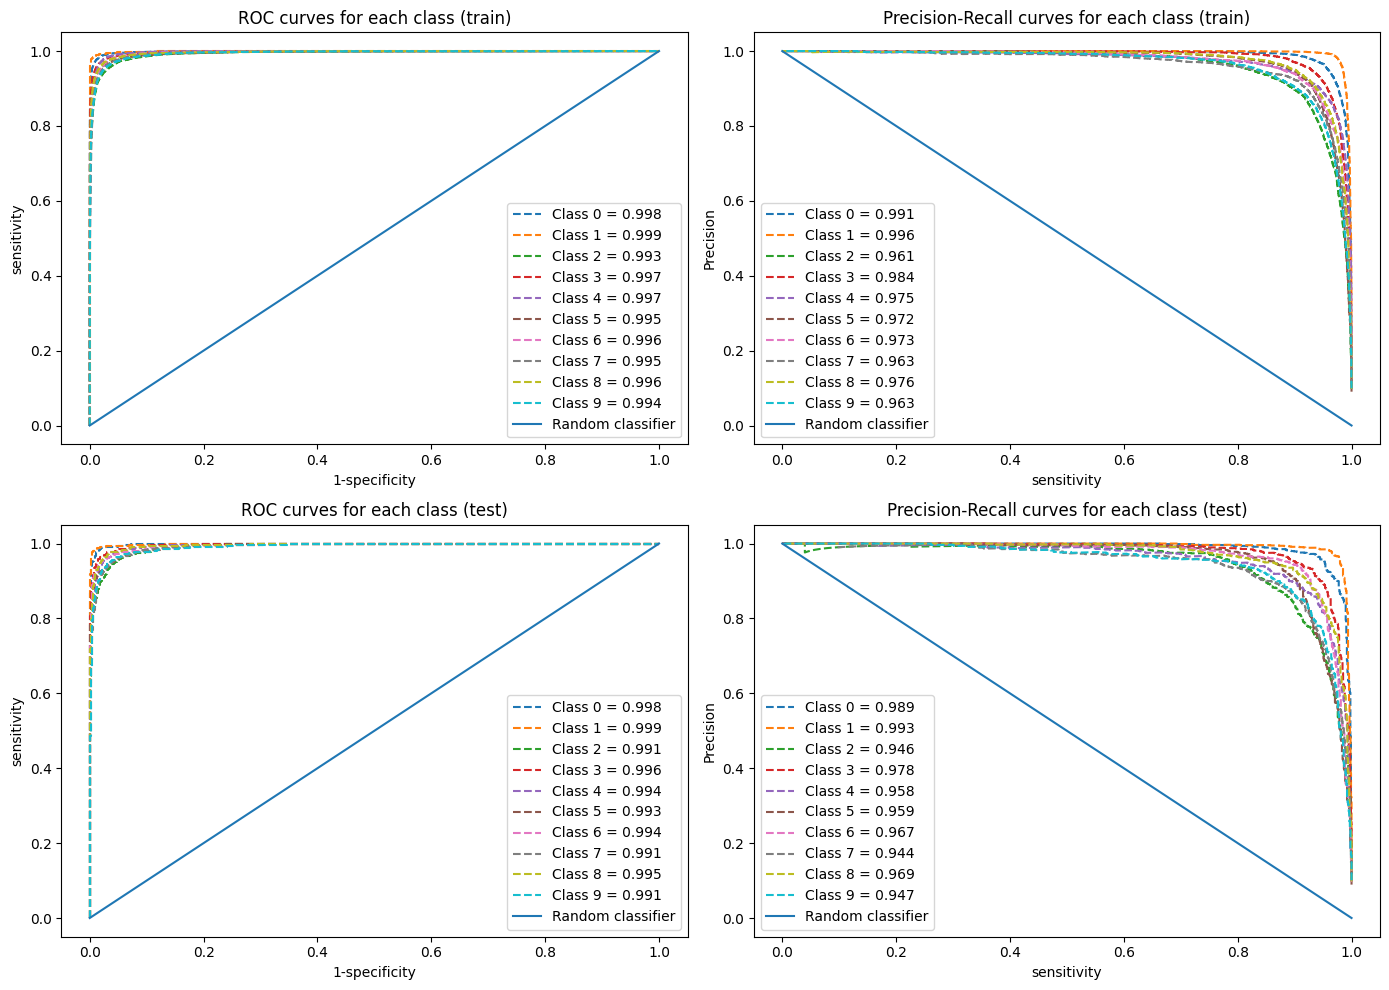

In [ ]:
# setting the axis for the final plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize = (14,10))
n_classes = 10

for i in range(n_classes):
    # we take the i-th class as the true labels
    # the only sequences with the label 1 will be that of the class i
    # the others will be at 0
    y_train_true = train_labels[:, i]
    y_test_true = test_labels[:, i]

    # calculate the predicted classes for train et test sets
    # we take the i-th class predictions
    train_pred = cnn_3_model.predict(train_images, verbose=0)[:, i]
    test_pred = cnn_3_model.predict(test_images, verbose=0)[:, i]

    # roc_curve enables to set thresholds and calculate FPR and TPR
    train_fpr, train_tpr, _ = roc_curve(y_train_true, train_pred)
    test_fpr, test_tpr, _ = roc_curve(y_test_true, test_pred)

    # calculate the area under the ROC curve
    auc_train = sklearn.metrics.auc(train_fpr, train_tpr)
    auc_test = sklearn.metrics.auc(test_fpr, test_tpr)

    ax1.plot(train_fpr, train_tpr, linestyle='--', label=f"Class {i} = {auc_train:.3f}")
    ax3.plot(test_fpr, test_tpr, linestyle='--', label=f"Class {i} = {auc_test:.3f}")

    # procede the same for precision-recall
    train_precision, train_recall, _ = precision_recall_curve(y_train_true, train_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test_true, test_pred)

    aupr_train = sklearn.metrics.average_precision_score(y_train_true, train_pred)
    aupr_test = sklearn.metrics.average_precision_score(y_test_true, test_pred)

    ax2.plot(train_recall, train_precision, linestyle='--', label=f"Class {i} = {aupr_train:.3f}")
    ax4.plot(test_recall, test_precision, linestyle='--', label=f"Class {i} = {aupr_test:.3f}")

# plot the random classifier for comparison
ax1.plot([0, 1], [0, 1], label='Random classifier')
ax1.set_xlabel('1-specificity')
ax1.set_ylabel('sensitivity')
ax1.set_title('ROC curves for each class (train)')
ax3.plot([0, 1], [0, 1], label='Random classifier')
ax3.set_xlabel('1-specificity')
ax3.set_ylabel('sensitivity')
ax3.set_title('ROC curves for each class (test)')

ax2.plot([0, 1], [1, 0], label='Random classifier')
ax2.set_xlabel('sensitivity')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves for each class (train)')
ax4.plot([0, 1], [1, 0], label='Random classifier')
ax4.set_xlabel('sensitivity')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall curves for each class (test)')

# to separate correctly each sub-graph
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

**Interpretation:**

This last model is better than our previous CNN models and dense one. This suppose that adding more layer improves the performances. However, due to execution issues (more than 4 hours for a cross-validation to run), I couldn't work more on this idea.